# Multiple Linear Regression to predict Insurance Cost

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("Dataset/insurance.csv")

In [3]:
# Display data
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
print(dict(enumerate(df["region"].astype("category").cat.categories)))

{0: 'northeast', 1: 'northwest', 2: 'southeast', 3: 'southwest'}


In [5]:
# Analyze potential missing values / NaN (Result: We do not have any missing values)
df[df.isnull().any(axis=1)]

,age,sex,bmi,children,smoker,region,charges


In [6]:
# Label encoded: Converted categorical labels into integer codes for best practice
cols_le = LabelEncoder()
col = ["sex", "smoker", "region"]
for c in col:
    df[c] = cols_le.fit_transform(df[c])

In [7]:
corr = df.select_dtypes(include=['number']).corr()["charges"]
corr

age         0.299008
sex         0.057292
bmi         0.198341
children    0.067998
smoker      0.787251
region     -0.006208
charges     1.000000
Name: charges, dtype: float64

In [8]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


Lets take a look at the bar plot for a better visual understanding.

Text(0, 0.5, 'Correlation level')

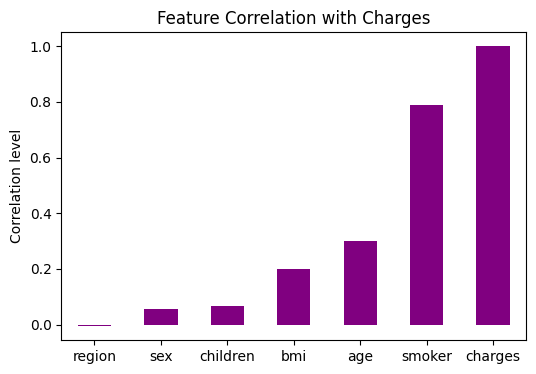

In [9]:
ax = corr.sort_values().plot.bar(figsize=(6,4), color="purple")

ax.tick_params(axis="x", labelrotation=0)
ax.set_title("Feature Correlation with Charges")
ax.set_ylabel("Correlation level")

Text(0.5, 1.0, 'Distribution of Non-Smokers')

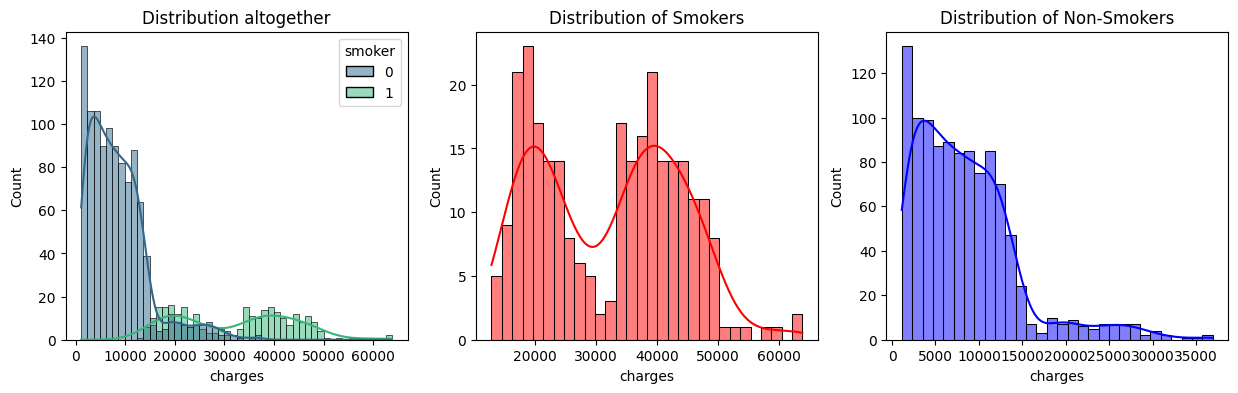

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(data=df, x="charges", hue="smoker", kde=True, bins=50, palette="viridis", ax=axes[0])
axes[0].set_title("Distribution altogether")

sns.histplot(data=df[df["smoker"] == 1], x="charges", bins=30, color="red", kde=True, ax=axes[1])
axes[1].set_title("Distribution of Smokers")
sns.histplot(data=df[df["smoker"] == 0], x="charges", bins=30, color="blue", kde=True, ax=axes[2])
axes[2].set_title("Distribution of Non-Smokers")

Text(0.5, 1.0, 'Smoker vs Non-Smoker')

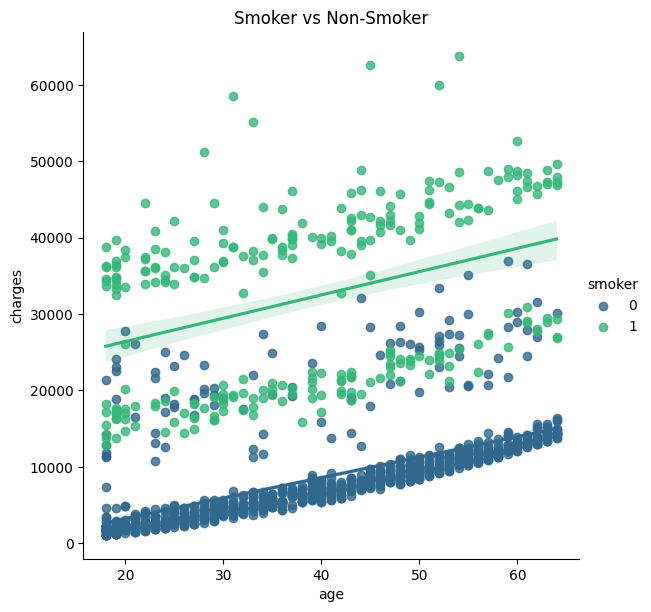

In [11]:
sns.lmplot(x="age", y="charges", hue="smoker", palette="viridis", height=6,data=df)
plt.title("Smoker vs Non-Smoker")

In [12]:
# Check mean
df.groupby("smoker")["charges"].mean()

smoker
0     8434.268298
1    32050.231832
Name: charges, dtype: float64

There is a high correlation between smoking status and charges, demonstrating that smokers tend to spend more on treatments.

# Data Preparation

In [13]:
# Prepare Data 5
df["region"] = df["region"].astype("int")
X = pd.get_dummies(df.drop(columns="charges"), drop_first=True)
y = df["charges"]    
X

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1
...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1
1334,18,0,31.920,0,0,0
1335,18,0,36.850,0,0,2
1336,21,0,25.800,0,0,3


In [14]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [15]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [16]:
# Train model by using training data to learn best intercept and slope
model = LinearRegression().fit(X_train, y_train)

# Bayesian Information Criterion (BIC)

BIC is a score used to select the best model by balancing how well the model fits the data (low error is better) and how simple the model is (fewer parameters is better)

---

## BIC Formula

$$
\text{BIC}
\;=\;
n \,\ln\!\left(\frac{\mathrm{RSS}}{n}\right)
\;+\;
k \,\ln n
$$

where  
- \(n\) is the number of observations,  
- $\mathrm{RSS} \;=\; \sum_{i=1}^{n}\bigl(y_i - \hat y_i\bigr)^{2}$ is the residual sum of squares,  that measures the distance between each observed point and its model predicted values.
- \(k\) is the number of estimated parameters (slopes + intercept).

---

# Multiple Linear Regression
Using the training data, we predict the response $Y$ from $p$ predictor variables
$(X_1, X_2, \dots, X_p)$ via

## Formu)
 vi$$
Y_i
= \beta_0
+ \beta_1 X_{1i}
+ \beta_2 X_{2i}
+ \dots
+ \beta_p X_{pi}
+ \varepsilon_i,
\qquad
i = 1, 2, \dots, n.
$$

- $Y_i$ is the response for observation $i$  
- $X_{ji}$ is the value of predictor $X_j$ for observation $i$  
- $\beta_0$ is the intercept  
- $\beta_j$ (for $j = 1,\dots,p$) are the slope coefficients—each represents the change in $Y$ per one-unit increase in $X_j$ **holding the other predictors constant**  
- $\varepsilon_i$ is the random error term, typically assumed i.i.d.\ with mean $0$ and constant variance $\sigma^{2}$onstant variance \(\sigma^{2}\).and constant variance $\sigma^{2}$.

In [17]:
# BIC calculation 
y_pred_train = model.predict(X_train) # Compute residual on training data for r^2
y_pred_test = model.predict(X_test) # Compute residual on testing data for r^2

In [18]:
# Now we plug in the values for the BIC formula
n, p = X_train.shape
rss = np.sum((y_train - y_pred_train)**2)
# Slopes + intercept
k = p + 1
bic = n * np.log(rss / n) + k * np.log(n)

In [19]:
# Root-Mean-Squared Error
error = root_mean_squared_error(y_test, y_pred_test)

In [20]:
print(f"BIC: {bic:,.0f}")
# Compare results
print(f"Test r^2: {r2_score(y_test, y_pred_test):.3f}")
print(f"RMSE: {error:,.0f}")
print(f"Training r^2: {r2_score(y_train, y_pred_train):.3f}")

BIC: 18,697
Test r^2: 0.753
RMSE: 5,893
Training r^2: 0.749


With our testing and training r^2 values, it seems like our models are not overfitting. And are able to capure most of the differences in the data. 

Our RMSE is within about $6k of the true cost of charges.

In [21]:
for degree in range(1, 6):
    # Use polynomial features and fit
    X_pol = PolynomialFeatures(degree, include_bias=False).fit_transform(X)
    # Split
    X_tr, X_te, y_tr, y_te = train_test_split(X_pol, y, test_size=0.2, random_state=0)

    # fit model
    model = LinearRegression().fit(X_tr, y_tr)

    # Compute BIC
    rss = np.sum((y_tr - model.predict(X_tr))**2)
    n, p = X_tr.shape
    # Slopes + intercept
    k = p + 1
    bic = n * np.log(rss / n) + k * np.log(n)

    # To check R^2 values on test data
    y_pred = model.predict(X_te)
    r2_test = r2_score(y_te, y_pred)

    print(f"degree:{degree} BIC={bic:,.0f} R^2 = {r2_test:.3f}")

degree:1 BIC=18,716 R^2 = 0.800
degree:2 BIC=18,356 R^2 = 0.881
degree:3 BIC=18,683 R^2 = 0.878
degree:4 BIC=19,467 R^2 = 0.861
degree:5 BIC=21,030 R^2 = 0.813


The degree 2 model offers a strong balance between model simplicity and predictive power. It has a few extra parameters and achieves a higher test R square. 

## Fitting our Final Model

In [22]:
# Use make_pipeline that lets us chain preprocessing steps
fin_model = make_pipeline(
                          PolynomialFeatures(degree=2, include_bias=False),
                          StandardScaler(),
                          LinearRegression()
                         )

In [23]:
# Fit final model using the split data
fin_model.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [24]:
y_pred_test = fin_model.predict(X_test)
y_pred_train = fin_model.predict(X_train)
mse = cross_val_score(fin_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
mean_mse=np.mean(mse)
print(f"Mean of mse:, {mean_mse:.3f}")
print(f"R^2 test: {r2_score(y_test, y_pred_test):.3f}")
print(f"R^2 train: {r2_score(y_train, y_pred_train):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred_test):.3f}")

Mean of mse:, -24071894.358
R^2 test: 0.851
R^2 train: 0.845
RMSE: 4579.218


Our root mean squared error reduced as it is closest to the actual values in the dataset. 
The r-squared value has increased which explains a larger fraction of the spread.

# Ridge Regression

Ordinary least squares linear regression plus an L2 penalty that discourages the model from using large values for the coefficients. 

- Reduces/prevent overfitting (High variance, low bias)
- Controls multicollinearity from obtaining dramatically different weights.

$$
\text{Loss}\;=\;\sum_{i=1}^{n}(y_i-\hat y_i)^2
\;+\;\lambda\sum_{j=1}^{p}\beta_j^{2}
$$$$

In [36]:
# Using Ridge regression
ridge_pipe = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
                           StandardScaler(),
                           Ridge()
                          )

params={'ridge__alpha':[1e-15,1e-10, 1e-8,1e-3,1e-2,1,5,10,20, 30, 35, 40, 45, 50, 55, 100]}
ridge_regressor=GridSearchCV(ridge_pipe,params,scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False)),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1,
                                          5, 10, 20, 30, 35, 40, 45, 50, 55,
                                          100]},
             scoring='neg_mean_squared_error')

In [37]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'ridge__alpha': 1}
-24095857.10940332


In [38]:
y_pred_test = ridge_regressor.predict(X_test)
y_pred_train = ridge_regressor.predict(X_train)

print(f"R^2 test: {r2_score(y_test, y_pred_test):.3f}")
print(f"R^2 train: {r2_score(y_train, y_pred_train):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred_test):.3f}")

R^2 test: 0.851
R^2 train: 0.844
RMSE: 4575.900


# Lasso Regression
Ordinary least squares linear regression plus an L1 penalty. 

By minimizing the sum of squared differences between the observed and predicted values by fitting a line to the data.

L1 regularization penalty reduces variance by making the coefficients of less important features to zero.

Increasing regularization strenngth such as raising the lambda value can increase bias (More chance of underfitting). (Stronger penalty can cause the model to oversimplify)

$$
\text{Loss}_\;=\;\sum_{i=1}^{n}(y_i-\hat y_i)^2
\;+\;\lambda\sum_{j=1}^{p}\lvert\beta_j\rvert
$$
$$

In [62]:

lasso_pipe = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
                           StandardScaler(),
                           Lasso(max_iter=20_000, random_state=42)
                          )
params={'lasso__alpha':[1e-15,1e-10, 1e-8,1e-3,1e-2,1,5,10,20, 30, 35, 40, 45, 50, 55, 100]}

In [64]:
lasso_regressor=GridSearchCV(lasso_pipe, params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=0)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False)),
                                       ('standardscaler', StandardScaler()),
                                       ('lasso',
                                        Lasso(max_iter=20000,
                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1,
                                          5, 10, 20, 30, 35, 40, 45, 50, 55,
                                          100]},
             scoring='neg_mean_squared_error')

In [65]:
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'lasso__alpha': 5}
-24089132.926518597


In [66]:
# R^2 with lasso regression
y_pred_lass=lasso_regressor.predict(X_test)
r2_score1=r2_score(y_pred_lass,y_test)
print(r2_score1)

0.8150680832713735


We have hit the ceiling for linear regression as no amount of L1 or L2 shrinkage can push R^2 beyond 0.85. 

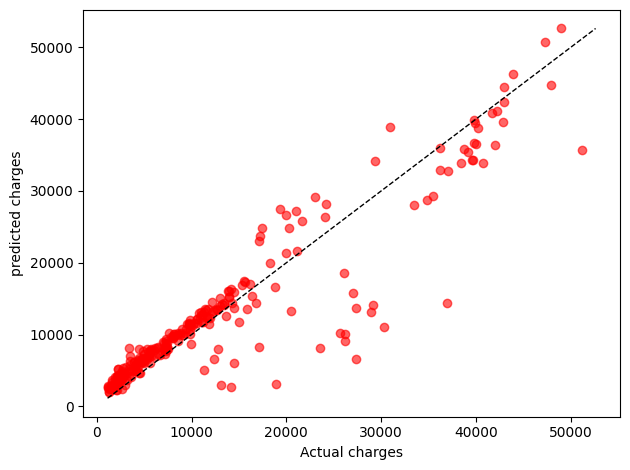

In [43]:
plt.scatter(y_test, y_pred_test, color="red", alpha=0.6)
mn = min(y_test.min(), y_pred_test.min())
mx = max(y_test.max(), y_pred_test.max())
plt.plot([mn, mx], [mn, mx], "k--", linewidth=1)
plt.xlabel("Actual charges")
plt.ylabel("predicted charges")
plt.tight_layout()
plt.show()

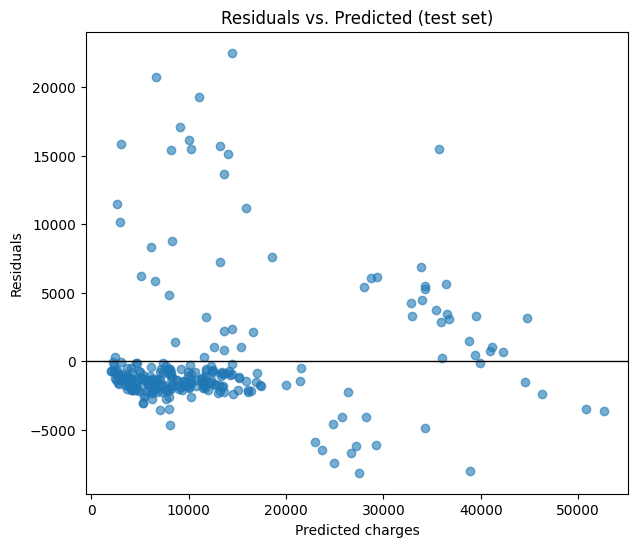

In [44]:
fig, ax = plt.subplots(figsize=(7,6))
res = y_test - y_pred_test
ax.scatter(y_pred_test, res, alpha=0.6)
plt.axhline(0, color="black", lw=1)
plt.xlabel("Predicted charges")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted (test set)")
plt.show()

Heteroscedasity: The variance of the error term is not the same for all observations.

Let us check with a method called the Breusch-Pagan test to determine whether or not heteroscedasity is present in our model.

If our p-value is less than significance level a = .05, then we reject null hypothesis and conclude that heteroscedasticity is present in the model.


In [49]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
res   = y_train - y_pred_train   
X_sm  = sm.add_constant(X_train)                  

bp_p   = het_breuschpagan(res, X_sm)[1]

print(f"Breusch-Pagan p = {bp_p:.4g}")


Breusch-Pagan p = 0.1019


Checking our p values, we failed to reject homoscedasticity which indicates that our multilinear regression residuals do not exhibit significant heteroscedasticity.

## Check for Multicollinearity

Multicollinearity occurs when independent variables are highly correlated which leads to unlreliable estimates. To detect multicollinearity, we will use Variance Inflation Factor that measures how much the variance of an estimates regression coefficient increases due to multicollinearity. 

- A VIF value of 1 indicates no multicollinearity.
- We should for VIF values below 5 or 10.

In [50]:
# replace ±inf with NaN and drop / impute any missing values
X_train.dropna(inplace=True)    
X_train_clean = X_train.replace([np.inf, -np.inf], np.nan, inplace=True)  

In [51]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
# 3) Add intercept *after* the split
X_train_const = sm.add_constant(X_train, has_constant='add')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train_const.values, i) 
              for i in range(X_train_const.shape[1])]
vif['Variable'] = X_train_const.columns           
print(vif)

         VIF  Variable
0  32.574579     const
1   1.015786       age
2   1.008837       sex
3   1.039273       bmi
4   1.002895  children
5   1.007831    smoker
6   1.026277    region


In [52]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


Our variables sit below the threshold of 5, which indicates that are predictors are esentially uncorrelated.

## Save Model

In [54]:
import joblib
joblib.dump(ridge_regressor.best_estimator_, "medical_cost_model.pk1")

['medical_cost_model.pk1']

In [55]:
# Load model to Predict on new data 
load_mod = joblib.load("medical_cost_model.pk1")

## Testing Saved Model

In [56]:
# Reference for region: {0: 'northeast', 1: 'northwest', 2: 'southeast', 3: 'southwest'}
data_to_predict = pd.DataFrame({
    "age": [20],
    "sex": [1],
    "bmi": [30],
    "children": [0],
    "smoker": [0],
    "region": [0]
})

pred_charge = load_mod.predict(data_to_predict)
    

In [57]:
print(f"Predicted charge: ${pred_charge[0]:,.0f}")

Predicted charge: $4,330
